In [1]:
import pandas as pd


data = pd.read_excel("open_crosion.xlsx")
data.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Label,Experiment,X-Coordinate,Y-Coordinate,Specimen
0,-0.793526,-0.564884,-0.918486,-2.643592,-0.405808,1.555672,-1.282668,1,5,53.5,40.0,1
1,-1.131818,-0.564884,-0.934511,-2.750356,-0.279310,1.275645,-2.688708,1,5,54.0,30.5,1
2,-1.120734,-0.564884,-0.951459,-2.863264,-0.298150,1.378301,-2.487164,1,5,54.0,31.0,1
3,-1.106464,-0.564884,-0.968407,-2.976173,-0.316991,1.480956,-2.505143,1,5,54.0,31.5,1
4,-1.090652,-0.564884,-0.985354,-3.089081,-0.335831,1.583612,-2.578003,1,5,54.0,32.0,1


In [ ]:
# Analyzing the class distribution in the 'Label' column
class_distribution = data['Label'].value_counts()
class_distribution_percentage = data['Label'].value_counts(normalize=True) * 100

class_distribution, class_distribution_percentage


### Undersampling the Majority class

In [2]:
from sklearn.utils import resample

# Separating the majority and minority classes
majority_class = data[data['Label'] == 0]
minority_class = data[data['Label'] == 1]

# Undersampling the majority class
majority_class_undersampled = resample(majority_class, 
                                       replace=False,    # sample without replacement
                                       n_samples=len(minority_class), # to match minority class
                                       random_state=123) # reproducible results

# Combining the minority class with the downsampled majority class
undersampled_data = pd.concat([majority_class_undersampled, minority_class])

# Checking the new class distribution
new_class_distribution = undersampled_data['Label'].value_counts()
new_class_distribution_percentage = undersampled_data['Label'].value_counts(normalize=True) * 100

undersampled_data, new_class_distribution, new_class_distribution_percentage


(       Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
 6001   -1.531516  -1.129767  -0.021229   0.025999  -0.864924   2.450809   
 42520   1.750273  -0.564884   0.460397   0.788435   0.453337  -0.533535   
 43039   1.377773  -1.129767   0.337808  -0.028268   0.492612   0.179461   
 24051  -0.731862  -0.564884  -1.006472   0.281063  -0.596166   0.298817   
 37052  -2.102502  -2.824418   1.513263   0.867948   0.397445  -0.420319   
 ...          ...        ...        ...        ...        ...        ...   
 1949   -0.711340  -0.564884  -1.611781  -4.649172   0.075553  -0.212730   
 1950   -0.692561  -0.564884  -1.625033  -4.737464   0.069007  -0.230745   
 1951   -0.657889  -0.564884  -1.612847  -4.656280   0.070719  -0.238682   
 1952   -0.669295  -0.564884  -1.593393  -4.526674   0.074789  -0.243738   
 1953   -0.671339  -0.564884  -1.573939  -4.397068   0.078859  -0.248795   
 
        Feature 7  Label  Experiment  X-Coordinate  Y-Coordinate  Specimen  
 6001    

### Logistic Regression on Balance Dataset

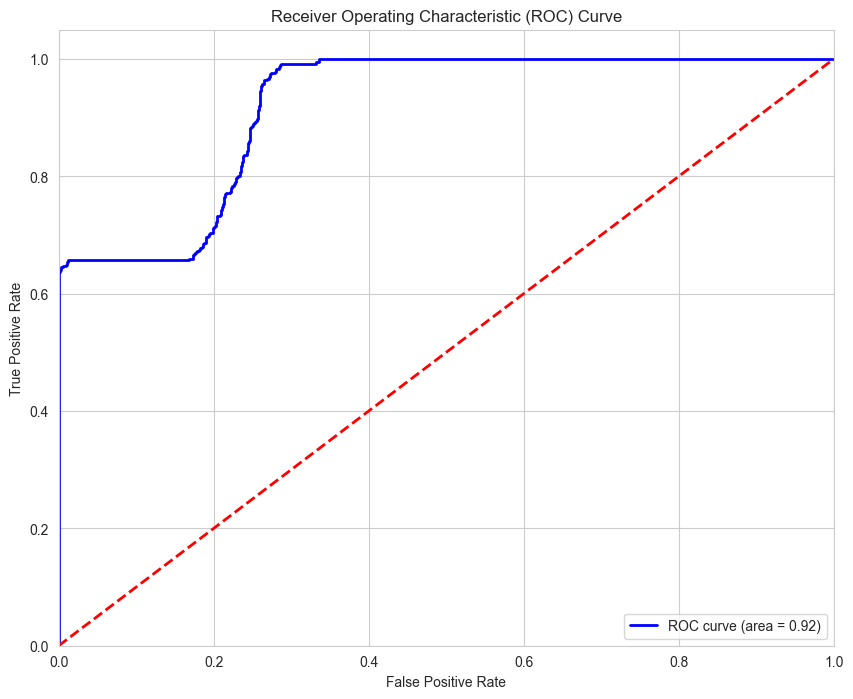

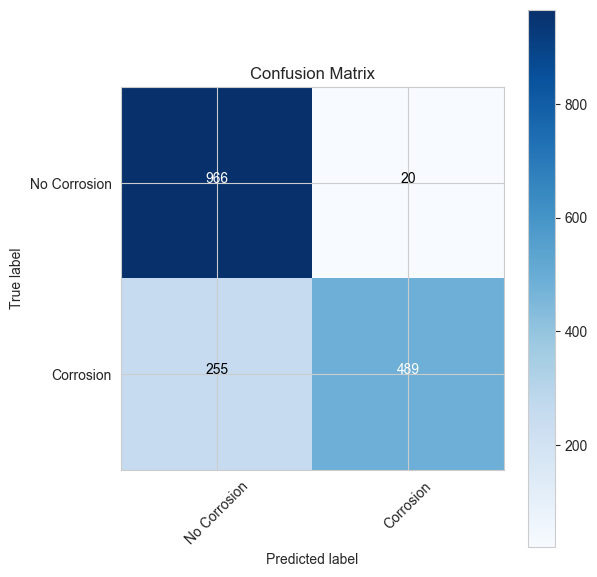

(0.8410404624277457,
 array([[966,  20],
        [255, 489]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.79      0.98      0.88       986\n           1       0.96      0.66      0.78       744\n\n    accuracy                           0.84      1730\n   macro avg       0.88      0.82      0.83      1730\nweighted avg       0.86      0.84      0.83      1730\n')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Selecting relevant features and the target variable
features = ['Feature 3', 'Feature 4', 'Feature 5', 'Feature 6']
target = 'Label'

# Splitting the data based on specimen
train_data = undersampled_data[undersampled_data['Specimen'] == 1]
test_data = undersampled_data[undersampled_data['Specimen'] == 2]

# Preparing training and testing sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Creating and fitting the logistic regression model
model_log_reg_balanced_dataset = LogisticRegression()
model_log_reg_balanced_dataset.fit(X_train, y_train)

# Predicting on the test set
y_pred = model_log_reg_balanced_dataset.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Calculating ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, model_log_reg_balanced_dataset.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Corrosion', 'Corrosion'], rotation=45)
plt.yticks(tick_marks, ['No Corrosion', 'Corrosion'])

# Annotating the confusion matrix
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

accuracy, conf_matrix, class_report


# Logistic Regression on Unbalance data

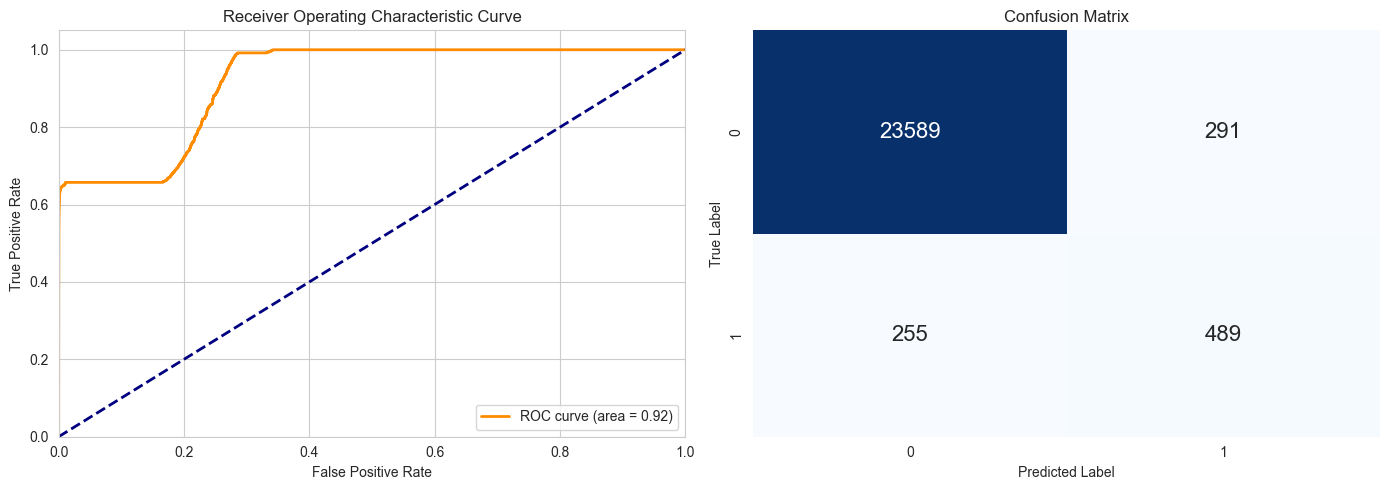

('              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99     23880\n           1       0.63      0.66      0.64       744\n\n    accuracy                           0.98     24624\n   macro avg       0.81      0.82      0.82     24624\nweighted avg       0.98      0.98      0.98     24624\n',
 array([[23589,   291],
        [  255,   489]], dtype=int64),
 0.919575588516057)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


data = pd.read_excel("open_crosion.xlsx")
# Splitting the data into training set from specimen 1 and testing set from specimen 2
specimen_1_data = data[data['Specimen'] == 1]
specimen_2_data = data[data['Specimen'] == 2]

input_features = ['Feature 3', 'Feature 4', 'Feature 5', 'Feature 6']
target_variable = 'Label'

X_train = specimen_1_data[input_features]
y_train = specimen_1_data[target_variable]

X_test = specimen_2_data[input_features]
y_test = specimen_2_data[target_variable]

# Initializing and training the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predicting the probabilities and converting to binary predictions using a 0.5 threshold
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluating the model
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculating the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the results
sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# Subplot 2: Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Adjusting layout
plt.tight_layout()
plt.show()

classification_rep, confusion_mat, roc_auc


### Adaptive Sampling with two Criteria - Using Unbalance Logistic Regression on  Experiment 17

Corrosion detected in iteration 4.


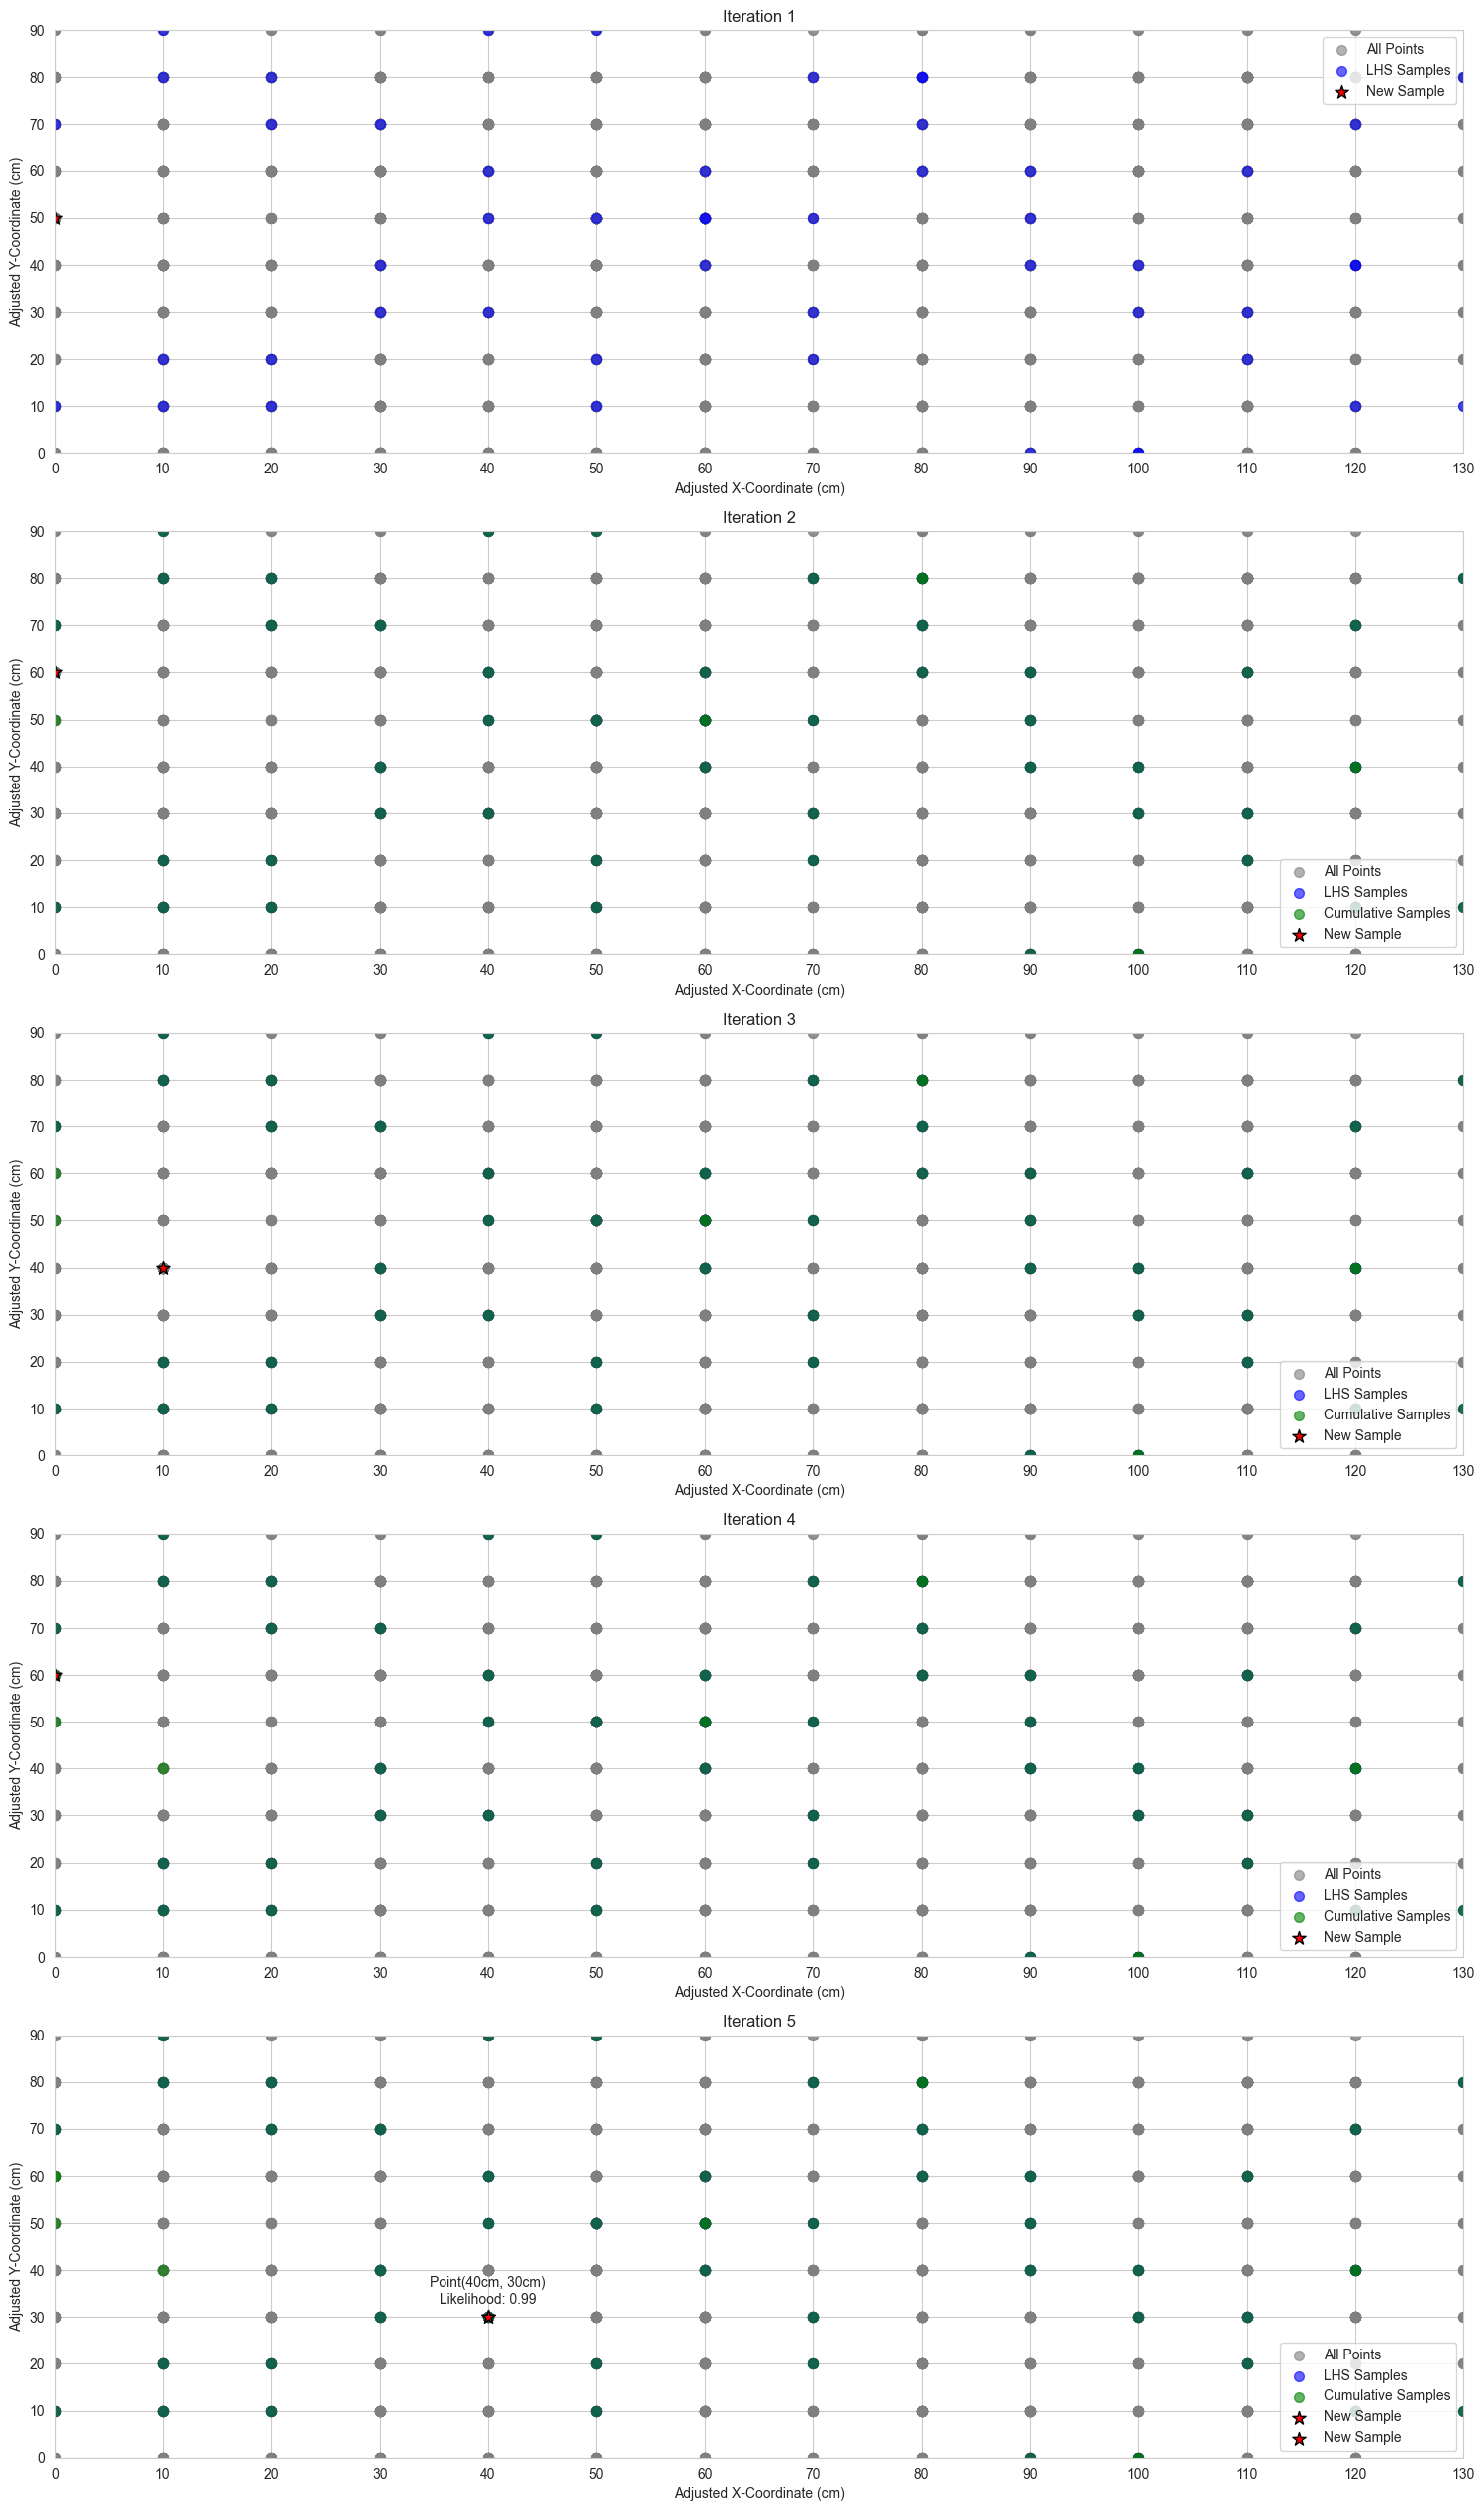

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Your data loading and coordinate adjustment code
data = pd.read_excel("open_crosion.xlsx")

# Determine the boundaries of the current X and Y coordinates
x_min, x_max = data['X-Coordinate'].min(), data['X-Coordinate'].max()
y_min, y_max = data['Y-Coordinate'].min(), data['Y-Coordinate'].max()

# Adjust the coordinates to fit the 13x10 grid for the 130x90 cm measurement field
data['X-Coordinate_Adjusted_10'] = (data['X-Coordinate'] / 10).round().astype(int)
data['Y-Coordinate_Adjusted_10'] = (data['Y-Coordinate'] / 10).round().astype(int)

# Setup GPR Model
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel)

def latin_hypercube_sampling(data, n_samples):
    """Generate Latin Hypercube Samples from data."""
    # Divide the range of data into n_samples intervals
    intervals = np.linspace(0, 1, n_samples + 1)
    # Randomly select a point within each interval
    random_samples = [np.random.uniform(low=intervals[i], high=intervals[i+1]) for i in range(n_samples)]
    # Shuffle the array to ensure randomness
    np.random.shuffle(random_samples)
    # Scale the random values to the actual range of the data
    scaled_samples = [sample * (data.max() - data.min()) + data.min() for sample in random_samples]
    return scaled_samples


# Filter data for Experiment 18
data_17 = data[data['Experiment'] == 18]
# Resetting the index for data_18
data_17 = data_17.reset_index(drop=True)

# Now you can use this function in your code as before
lhs_x_samples = latin_hypercube_sampling(data_17['X-Coordinate_Adjusted_10'], 50)
lhs_y_samples = latin_hypercube_sampling(data_17['Y-Coordinate_Adjusted_10'], 50)


initial_samples = []
for x, y in zip(lhs_x_samples, lhs_y_samples):
    distances = np.sqrt((data_17['X-Coordinate_Adjusted_10'] - x) ** 2 + (data_17['Y-Coordinate_Adjusted_10'] - y) ** 2)
    nearest_point = data_17.iloc[distances.idxmin()]
    initial_samples.append(nearest_point)


# Initial LHS samples
lhs_samples = pd.DataFrame(initial_samples)
cumulative_samples = lhs_samples.copy()  # To include new samples in each iteration
unselected_data = data_17.drop(lhs_samples.index)


def plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample, iteration, criteria_met, likelihood):
    plt.subplot(10, 1, iteration + 1)
    # ... existing plotting code ...
    plt.scatter(data_17['X-Coordinate_Adjusted_10'] * 10, data_17['Y-Coordinate_Adjusted_10'] * 10, 
                color='gray', s=50, alpha=0.6, label='All Points')

    # Plot LHS samples
    plt.scatter(lhs_samples['X-Coordinate_Adjusted_10'] * 10, lhs_samples['Y-Coordinate_Adjusted_10'] * 10, 
                color='blue', s=50, alpha=0.6, label='LHS Samples')

    # From the second iteration onwards, include cumulative samples
    if iteration > 0:
        plt.scatter(cumulative_samples['X-Coordinate_Adjusted_10'] * 10, cumulative_samples['Y-Coordinate_Adjusted_10'] * 10, 
                    color='green', s=50, alpha=0.6, label='Cumulative Samples')

    # Annotating the new sample point if criteria are met
    if criteria_met:
        x_coord = new_sample['X-Coordinate_Adjusted_10'].values[0] * 10
        y_coord = new_sample['Y-Coordinate_Adjusted_10'].values[0] * 10
        plt.scatter(x_coord, y_coord, color='red', s=100, edgecolor='k', marker='*', label='New Sample')
        plt.annotate(f'Point({x_coord}cm, {y_coord}cm)\nLikelihood: {likelihood:.2f}',
                     (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

    # ... rest of the plotting code ...
        # Always plot the new sample
    plt.scatter(new_sample['X-Coordinate_Adjusted_10'] * 10, new_sample['Y-Coordinate_Adjusted_10'] * 10, 
                color='red', s=100, edgecolor='k', marker='*', label='New Sample')

    plt.xlabel('Adjusted X-Coordinate (cm)')
    plt.ylabel('Adjusted Y-Coordinate (cm)')
    plt.title(f'Iteration {iteration + 1}')
    plt.grid(True)
    plt.xticks(np.arange(0, 131, 10))
    plt.yticks(np.arange(0, 91, 10))
    plt.xlim([0, 130])
    plt.ylim([0, 90])
    plt.legend()
# Initialize figure for adaptive sampling visualization
plt.figure(figsize=(15, 5 * 10))
# Main loop for adaptive sampling
for iteration in range(10):  # Set the number of iterations
    # ... existing sampling logic ...
        # Use logistic regression model for predictions
    X_selected = cumulative_samples[features]
    y_pred_proba = log_reg.predict_proba(X_selected)[:, 1]

    # Fit GPR Model based on logistic regression output
    gpr.fit(X_selected, y_pred_proba)

    # Predict for the rest of the data
    X_unselected = unselected_data[features]
    gpr_output, gpr_uncertainty = gpr.predict(X_unselected, return_std=True)

    # Select a new sample based on GPR output (e.g., highest uncertainty)
    idx_new_sample = np.argmax(gpr_uncertainty)
    new_sample = unselected_data.iloc[[idx_new_sample]]

    # Predicting label and likelihood for the new sample
    predicted_label = log_reg.predict(new_sample[features])
    predicted_proba = log_reg.predict_proba(new_sample[features])[:, 1][0]

    # Check if criteria are met
    criteria_met = predicted_label[0] == 1 and predicted_proba > 0.5

    # Update plot for each iteration including likelihood if criteria are met
    plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample, iteration, criteria_met, predicted_proba)

    # Break if criteria are met
    if criteria_met:
        print(f"Corrosion detected in iteration {iteration}.")
        break

    # ... rest of the loop ...
        # Update the sets of selected and unselected samples
    cumulative_samples = pd.concat([cumulative_samples, new_sample])

    # Drop the new sample from unselected_data using a boolean mask
    mask = unselected_data.index.isin(new_sample.index)
    unselected_data = unselected_data[~mask].reset_index(drop=True)

    # Check if the new point meets the criteria (corrosion detected with label == 1 and p > 0.5)
    predicted_label = log_reg.predict(new_sample[features])
    predicted_proba = log_reg.predict_proba(new_sample[features])[:, 1]

    if predicted_label[0] == 1 or predicted_proba[0] > 0.5:
        print(f"Corrosion detected in iteration {iteration}.")
        break

plt.tight_layout()
plt.show()


### Adaptive Sampling with two Criteria - Using balanced Logistic Regression on  Experiment 17

c:\Users\gzia\Documents\GitHub\reincarnate_wp2\.wp2\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Corrosion detected in iteration 0.


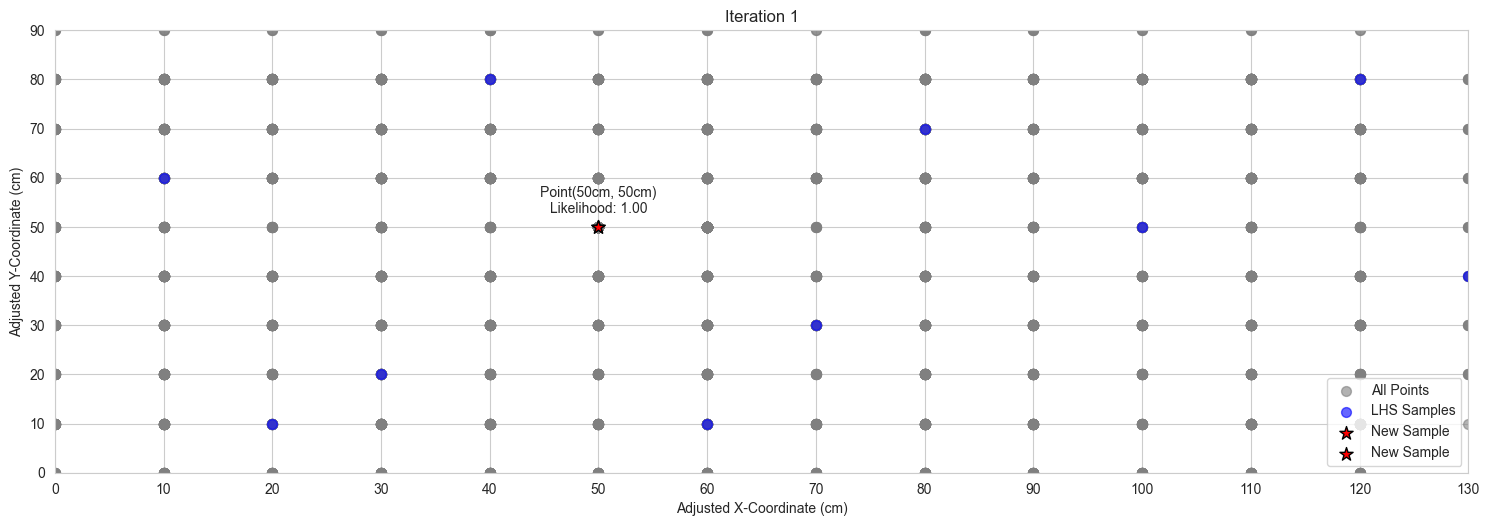

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Your data loading and coordinate adjustment code
data = pd.read_excel("open_crosion.xlsx")

# Determine the boundaries of the current X and Y coordinates
x_min, x_max = data['X-Coordinate'].min(), data['X-Coordinate'].max()
y_min, y_max = data['Y-Coordinate'].min(), data['Y-Coordinate'].max()

# Adjust the coordinates to fit the 13x10 grid for the 130x90 cm measurement field
data['X-Coordinate_Adjusted_10'] = (data['X-Coordinate'] / 10).round().astype(int)
data['Y-Coordinate_Adjusted_10'] = (data['Y-Coordinate'] / 10).round().astype(int)

# Setup GPR Model
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel)

def latin_hypercube_sampling(data, n_samples):
    """Generate Latin Hypercube Samples from data."""
    # Divide the range of data into n_samples intervals
    intervals = np.linspace(0, 1, n_samples + 1)
    # Randomly select a point within each interval
    random_samples = [np.random.uniform(low=intervals[i], high=intervals[i+1]) for i in range(n_samples)]
    # Shuffle the array to ensure randomness
    np.random.shuffle(random_samples)
    # Scale the random values to the actual range of the data
    scaled_samples = [sample * (data.max() - data.min()) + data.min() for sample in random_samples]
    return scaled_samples


# Filter data for Experiment 18
data_17 = data[data['Experiment'] == 18]
# Resetting the index for data_18
data_17 = data_17.reset_index(drop=True)

# Now you can use this function in your code as before
lhs_x_samples = latin_hypercube_sampling(data_17['X-Coordinate_Adjusted_10'], 10)
lhs_y_samples = latin_hypercube_sampling(data_17['Y-Coordinate_Adjusted_10'], 10)


initial_samples = []
for x, y in zip(lhs_x_samples, lhs_y_samples):
    distances = np.sqrt((data_17['X-Coordinate_Adjusted_10'] - x) ** 2 + (data_17['Y-Coordinate_Adjusted_10'] - y) ** 2)
    nearest_point = data_17.iloc[distances.idxmin()]
    initial_samples.append(nearest_point)


# Initial LHS samples
lhs_samples = pd.DataFrame(initial_samples)
cumulative_samples = lhs_samples.copy()  # To include new samples in each iteration
unselected_data = data_17.drop(lhs_samples.index)


def plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample, iteration, criteria_met, likelihood):
    plt.subplot(10, 1, iteration + 1)
    # ... existing plotting code ...
    plt.scatter(data_17['X-Coordinate_Adjusted_10'] * 10, data_17['Y-Coordinate_Adjusted_10'] * 10, 
                color='gray', s=50, alpha=0.6, label='All Points')

    # Plot LHS samples
    plt.scatter(lhs_samples['X-Coordinate_Adjusted_10'] * 10, lhs_samples['Y-Coordinate_Adjusted_10'] * 10, 
                color='blue', s=50, alpha=0.6, label='LHS Samples')

    # From the second iteration onwards, include cumulative samples
    if iteration > 0:
        plt.scatter(cumulative_samples['X-Coordinate_Adjusted_10'] * 10, cumulative_samples['Y-Coordinate_Adjusted_10'] * 10, 
                    color='green', s=50, alpha=0.6, label='Cumulative Samples')

    # Annotating the new sample point if criteria are met
    if criteria_met:
        x_coord = new_sample['X-Coordinate_Adjusted_10'].values[0] * 10
        y_coord = new_sample['Y-Coordinate_Adjusted_10'].values[0] * 10
        plt.scatter(x_coord, y_coord, color='red', s=100, edgecolor='k', marker='*', label='New Sample')
        plt.annotate(f'Point({x_coord}cm, {y_coord}cm)\nLikelihood: {likelihood:.2f}',
                     (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

    # ... rest of the plotting code ...
        # Always plot the new sample
    plt.scatter(new_sample['X-Coordinate_Adjusted_10'] * 10, new_sample['Y-Coordinate_Adjusted_10'] * 10, 
                color='red', s=100, edgecolor='k', marker='*', label='New Sample')

    plt.xlabel('Adjusted X-Coordinate (cm)')
    plt.ylabel('Adjusted Y-Coordinate (cm)')
    plt.title(f'Iteration {iteration + 1}')
    plt.grid(True)
    plt.xticks(np.arange(0, 131, 10))
    plt.yticks(np.arange(0, 91, 10))
    plt.xlim([0, 130])
    plt.ylim([0, 90])
    plt.legend()
# Initialize figure for adaptive sampling visualization
plt.figure(figsize=(15, 5 * 10))
# Main loop for adaptive sampling
for iteration in range(10):  # Set the number of iterations
    # ... existing sampling logic ...
        # Use logistic regression model for predictions
    X_selected = cumulative_samples[features]
    y_pred_proba = model_log_reg_balanced_dataset.predict_proba(X_selected)[:, 1]

    # Fit GPR Model based on logistic regression output
    gpr.fit(X_selected, y_pred_proba)

    # Predict for the rest of the data
    X_unselected = unselected_data[features]
    gpr_output, gpr_uncertainty = gpr.predict(X_unselected, return_std=True)

    # Select a new sample based on GPR output (e.g., highest uncertainty)
    idx_new_sample = np.argmax(gpr_uncertainty)
    new_sample = unselected_data.iloc[[idx_new_sample]]

    # Predicting label and likelihood for the new sample
    predicted_label = model_log_reg_balanced_dataset.predict(new_sample[features])
    predicted_proba = model_log_reg_balanced_dataset.predict_proba(new_sample[features])[:, 1][0]

    # Check if criteria are met
    criteria_met = predicted_label[0] == 1 and predicted_proba > 0.5

    # Update plot for each iteration including likelihood if criteria are met
    plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample, iteration, criteria_met, predicted_proba)

    # Break if criteria are met
    if criteria_met:
        print(f"Corrosion detected in iteration {iteration}.")
        break

    # ... rest of the loop ...
        # Update the sets of selected and unselected samples
    cumulative_samples = pd.concat([cumulative_samples, new_sample])

    # Drop the new sample from unselected_data using a boolean mask
    mask = unselected_data.index.isin(new_sample.index)
    unselected_data = unselected_data[~mask].reset_index(drop=True)

    # Check if the new point meets the criteria (corrosion detected with label == 1 and p > 0.5)
    predicted_label = log_reg.predict(new_sample[features])
    predicted_proba = log_reg.predict_proba(new_sample[features])[:, 1]

    if predicted_label[0] == 1 or predicted_proba[0] > 0.5:
        print(f"Corrosion detected in iteration {iteration}.")
        break

plt.tight_layout()
plt.show()
